### Guide d’utilisation du notebook de réduction de features

---

####  À lire avant d’exécuter le script

1. **Prérequis**  
   - Avoir préalablement extrait l’ensemble des features originales à l’aide de `pipeline_dataset.ipynb`.  
   - Placer ce notebook au même niveau que le dossier `Dataset` (contenant `Train` et `Test`).

2. **Choix des features à réduire**  
   - En début de notebook, décommentez ou commentez les lignes correspondant aux classes de features que vous souhaitez passer à la phase de réduction.

3. **Ordre d’exécution**  

   a. **Suppression des features à faible variance**  
   - Toutes les variables dont la variance est trop basse sont d’abord écartées.  

   b. **Analyse de corrélation**  
   - Calcul de la matrice de corrélation.  
   - Affichage de la matrice sous forme de heatmap et génération d’un dendrogramme pour visualiser les groupes de variables fortement corrélées.  

   c. **Sélection de sous-ensemble de features**  
   - Choix entre la méthode ANOVA ou mRMR.  
   - Par défaut : mRMR avec 50 features sélectionnées.

---



In [43]:
import os 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier         
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif


In [44]:
BASE_DIR = os.getcwd()

# look in the data folder and take the feature you want to reduced.
FEATURES_TO_ANALYSE = "shape_firstorder_glcm_glrlm_features"
# Shape + texture features 
DATA_DIR = os.path.join(BASE_DIR,"data",FEATURES_TO_ANALYSE)

TRAIN_DIR = os.path.join(DATA_DIR,"TrainningDataset.csv")
LABEL_DIR = os.path.join(DATA_DIR,"TrainningDatasetCategory.csv")
TEST_DIR = os.path.join(DATA_DIR,"TestingDataset.csv")


In [45]:
print(TRAIN_DIR)

/Users/rplanchon/Documents/telecom/IMA/S2/IMA205/Challenge/CardiacPathoPrediction/data/shape_firstorder_glcm_glrlm_features/TrainningDataset.csv


In [46]:
X = pd.read_csv(TRAIN_DIR)  # contient "Id"
y = pd.read_csv(LABEL_DIR)  # contient "Id" et "Category"

# S'assurer que les ID sont bien des chaînes formatées
X["Id"] = X["Id"].astype(str).str.zfill(3)
y["Id"] = y["Id"].astype(str).str.zfill(3)

# Aligner y sur l’ordre de X
y = y.set_index("Id").loc[X["Id"]].reset_index()
y_train = y["Category"]


In [47]:
X_train = X.drop(columns=["Id"])


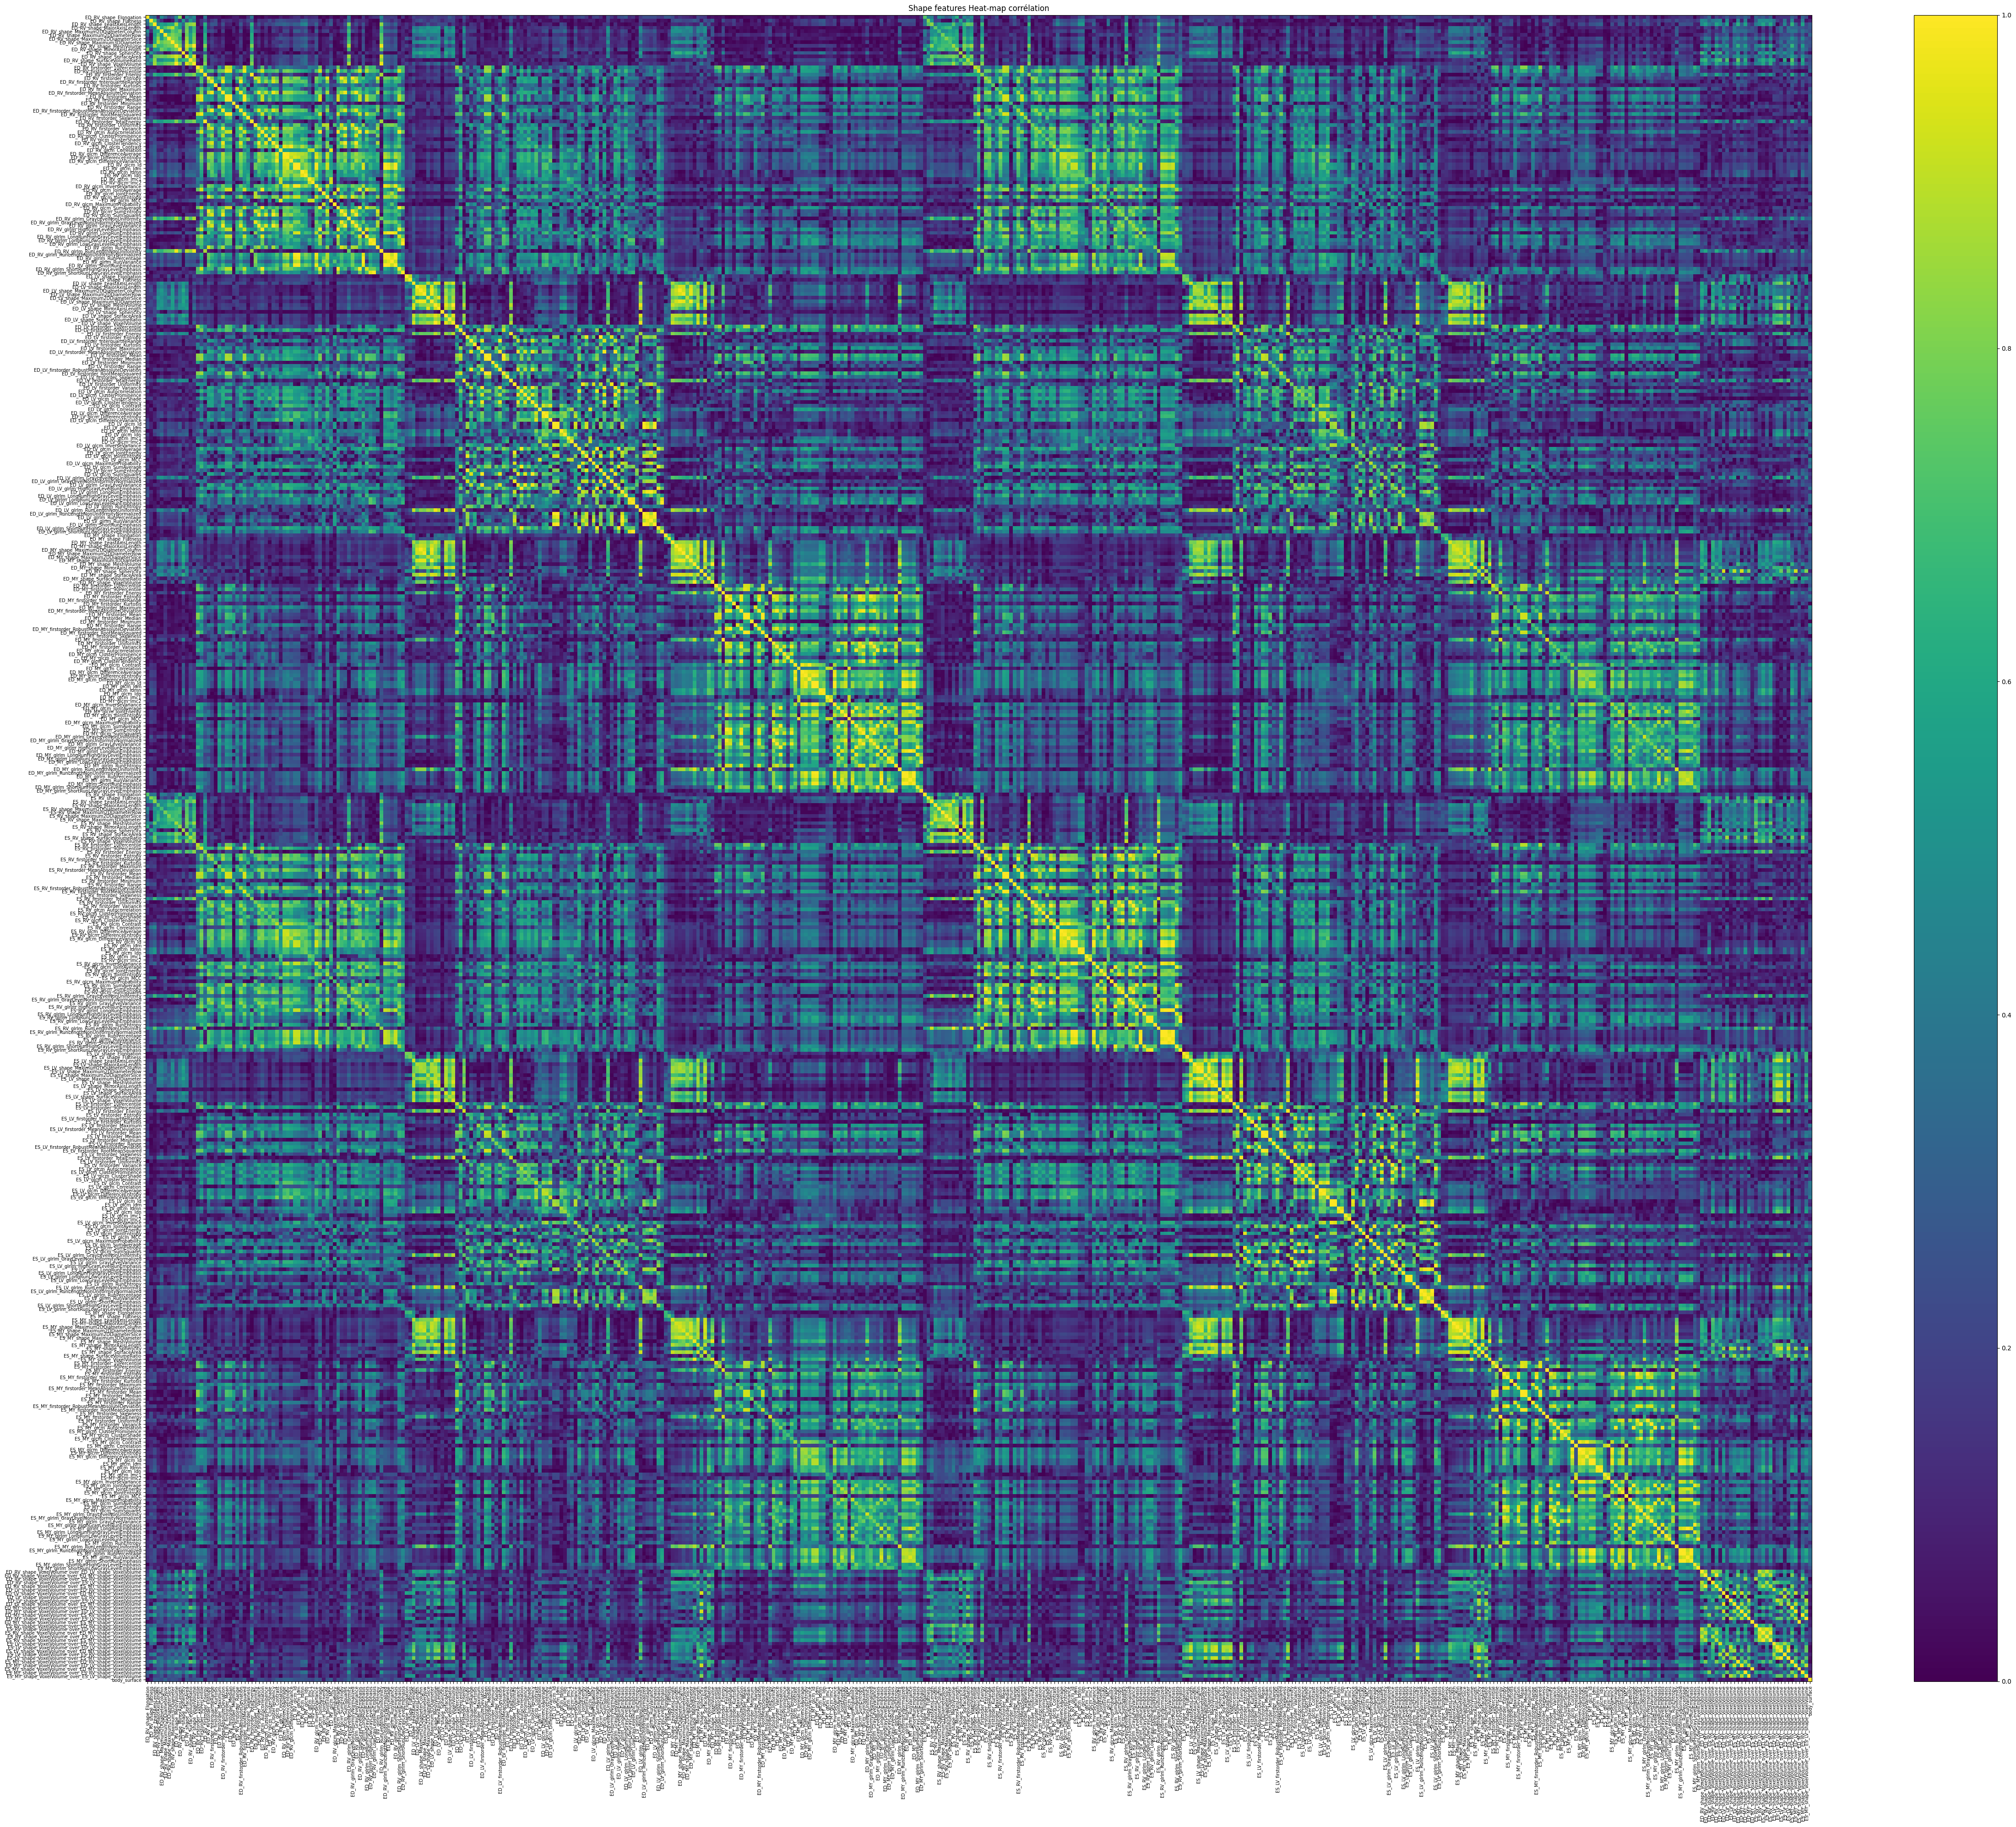

In [48]:
# Affichage de la Heat Map corrélation : on cherche à identifier les variables trop corrélés afin de les enlevés.
# En fonction du nombre de feature qu'on prend changer la figsize pour pouvoir voir.

scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)


corr = scaled_features.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(56, 40))
cax = ax.imshow(abs(corr), vmin=0, vmax=1, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=7)
ax.set_yticklabels(corr.columns, fontsize=7)
fig.colorbar(cax, fraction=0.046, pad=0.04)
plt.title("Shape features Heat-map corrélation")
plt.tight_layout()
#fig.savefig("heatmap_corr_glrlm_f.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

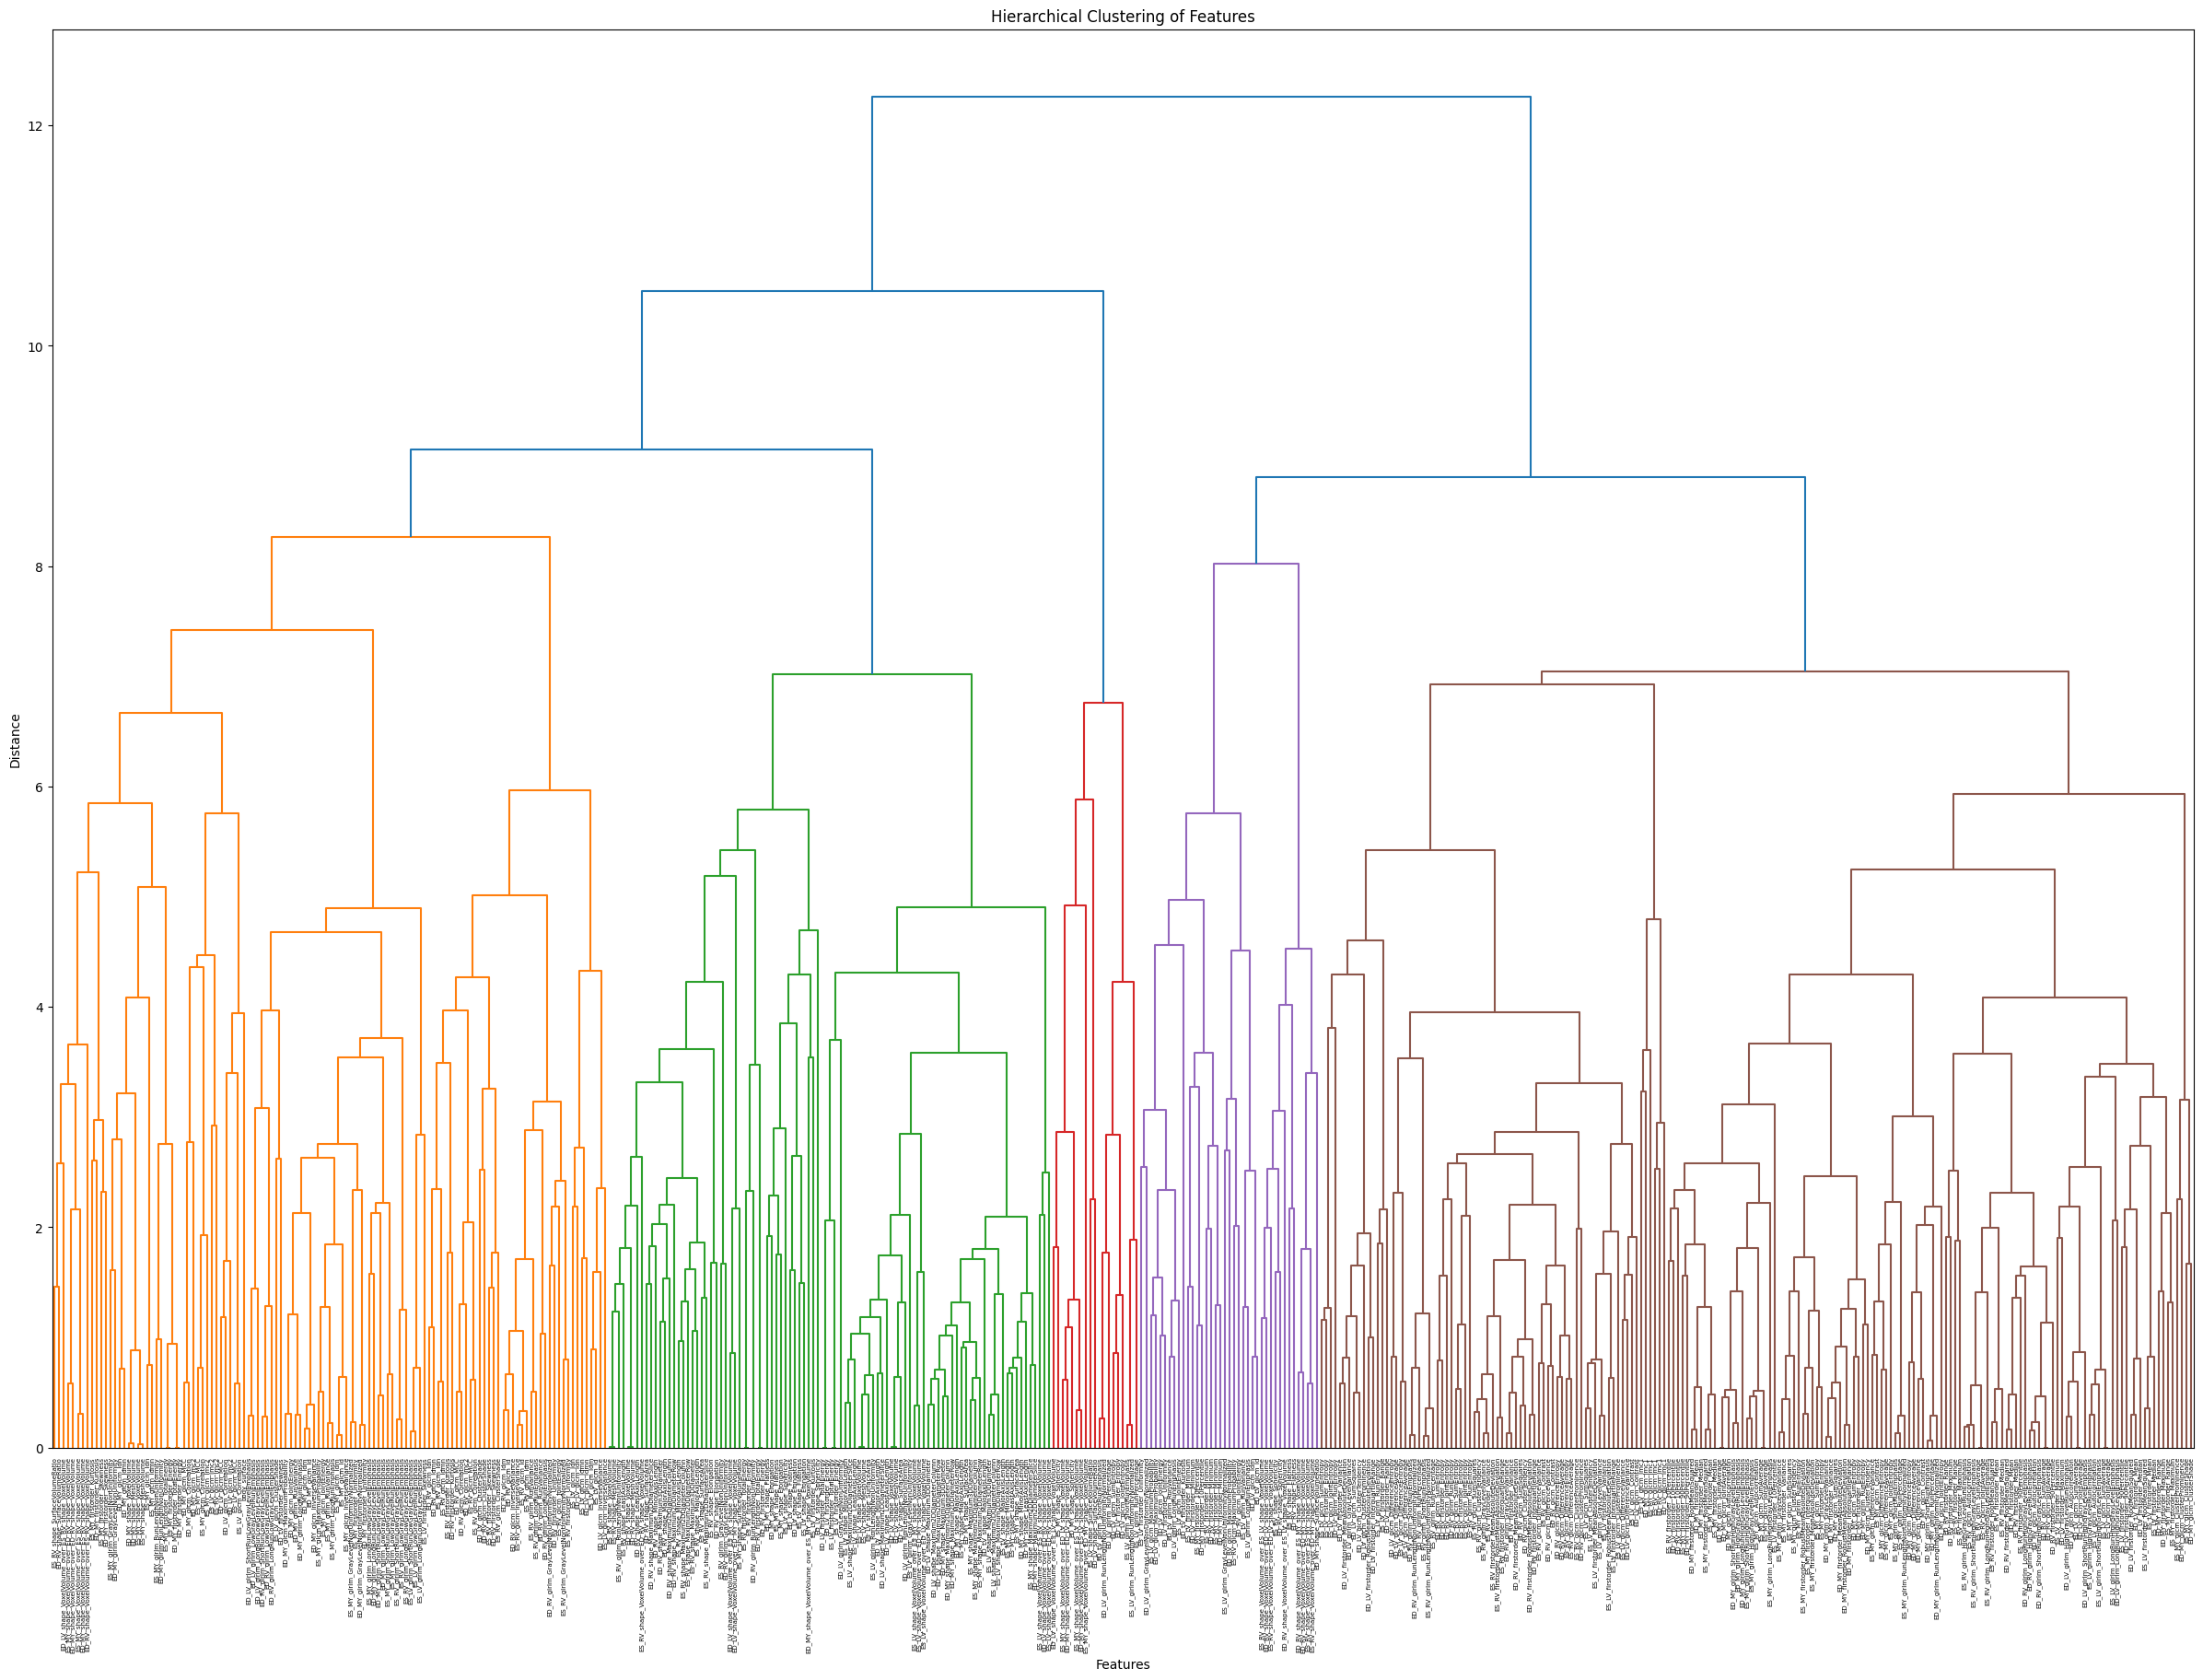

In [49]:
linkage_matrix = sch.linkage(1 - corr, method='average')


# We plot what is called a dendrogram to vizualize relationship between the different features.
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, labels=scaled_features.columns, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering of Features")
plt.xlabel("Features")
plt.ylabel("Distance")
plt.show()

In [50]:
# On retire les features avec une Variance trop faible. Pour l'instant je supprime juste les features constantes.

var_sel = VarianceThreshold(threshold=1e-3)     
X1 = var_sel.fit_transform(X_train)
selected_var = X_train.columns[var_sel.get_support()]
print(f"Number of features removed bc of too small variance : {len(X_train.columns) - len(selected_var)}")


Number of features removed bc of too small variance : 66


In [51]:
T = 0.92
def drop_high_corr(df, threshold=0.9):
    c = df.corr(numeric_only=True).abs()
    upper = c.where(np.triu(np.ones(c.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=to_drop), to_drop

X2_df, highly_corr = drop_high_corr(pd.DataFrame(X1, columns=selected_var), threshold=T)

print(f"Features retirées pour avec critère de corrélation > {T} : {len(highly_corr)}")
print(f"Nombre de features restantes : {X2_df.shape[1]}")


Features retirées pour avec critère de corrélation > 0.92 : 243
Nombre de features restantes : 154


# ATTENTION : 
- En dessous trois cellules consécutives : 
    Première : Annova feature selection 
    Deuxième : No More Feature selection 
    Troisième : mRMR Feature selection (50 by default)

**Soit vous executez uniquement la cellule que vous voulez soit par defaut si vous executez tout la dernière cellule va ecraser le resultat des autre** (ie par defaut mRMR)

In [38]:
# ANOVA. You can FORCE SELECTING FEATURE FROM EACH CATEGORIE

# Séparer les features par famille
shape_feats = [col for col in X2_df.columns if "shape" in col]
first_feats = [col for col in X2_df.columns if "firstorder" in col]
glcm_feats  = [col for col in X2_df.columns if "glcm" in col]
glrlm_feats = [col for col in X2_df.columns if "glrlm" in col] 

N_shape = 15
N_first = 5
N_glrlm = 5
N_glcm =  5

def select_kbest(X, y, columns, k):
    if not columns or k == 0:
        return []
    k = min(k, len(columns)) 
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X[columns], y)
    return list(np.array(columns)[selector.get_support()])


selected_shape = select_kbest(X2_df, y_train, shape_feats, N_shape)
selected_first = select_kbest(X2_df, y_train, first_feats, N_first)
selected_glcm  = select_kbest(X2_df, y_train, glcm_feats, N_glcm)
selected_glrlm = select_kbest(X2_df, y_train, glrlm_feats, N_glrlm) 

selected_final = selected_shape + selected_first + selected_glcm + selected_glrlm
print("Features retenues  :", selected_final)


Features retenues  : ['ED_LV_shape_LeastAxisLength', 'ED_MY_shape_MeshVolume', 'ED_MY_shape_Sphericity', 'ES_LV_shape_SurfaceVolumeRatio', 'ES_MY_shape_Sphericity', 'ES_MY_shape_SurfaceVolumeRatio', 'ED_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume', 'ED_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume', 'ED_RV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ED_LV_shape_VoxelVolume_over_ED_RV_shape_VoxelVolume', 'ED_LV_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ED_MY_shape_VoxelVolume_over_ED_RV_shape_VoxelVolume', 'ED_MY_shape_VoxelVolume_over_ES_LV_shape_VoxelVolume', 'ES_RV_shape_VoxelVolume_over_ED_LV_shape_VoxelVolume', 'ES_RV_shape_VoxelVolume_over_ED_MY_shape_VoxelVolume', 'ED_LV_firstorder_Energy', 'ED_MY_firstorder_Energy', 'ES_RV_firstorder_Energy', 'ES_LV_firstorder_Skewness', 'ES_MY_firstorder_Entropy', 'ED_MY_glcm_Contrast', 'ED_MY_glcm_Correlation', 'ES_MY_glcm_Contrast', 'ES_MY_glcm_Correlation', 'ES_MY_glcm_Imc1', 'ED_RV_glrlm_GrayLevelNonUniformity', 'ED_

In [39]:
# NO FURTHER FEATURE REDUCTION : 

selected_final = X2_df.columns.to_list()

In [52]:
# mRMR FEATURE SELECTION : (50 by default)

import sklearn_mrmr.mrmr
N_features_to_select = 100
mrmr_sel = sklearn_mrmr.mrmr.MRMRFeatureSelector(n_features_to_select=N_features_to_select)
selected_final = list(mrmr_sel.fit_transform(X2_df, y_train).columns)


In [53]:

pd.Series(selected_final).to_csv(os.path.join(DATA_DIR, "SelectedFeatures.csv"), index=False, header=["Feature"])

X_train_reduced = X[["Id"] + selected_final]


X_train_reduced.to_csv(os.path.join(DATA_DIR, "TrainningDataset_reduced.csv"), index=False)



In [54]:
# use the same feature for the test set. 
# Ensure that the test set uses the same 'Id' as the training set

X_test = pd.read_csv(os.path.join(DATA_DIR,"TestingDataset.csv"))
X_test_reduced = pd.DataFrame(X_test,columns=X_train_reduced.columns)
X_test_reduced.to_csv(os.path.join(DATA_DIR, "TestingDataset_reduced.csv"), index=False)
